## Read the feature selected  data frame via mutual information

In [5]:
import pandas as pd
import numpy as np
import time

np.random.seed(33)
df = pd.read_csv("data/featureSelectedAllDataWithY.csv")
# df = pd.read_csv("../data/Cleaned_dat_encoded.csv")
print(df.shape)
df.head()

(534730, 21)


,esi,age,ethnicity,race,lang,maritalstatus,employstatus,insurance_status,arrivalmode,previousdispo,...,meds_analgesics,meds_antiplateletdrugs,meds_cardiacdrugs,meds_cardiovascular,meds_diuretics,meds_elect/caloric/h2o,meds_gastrointestinal,meds_psychotherapeuticdrugs,meds_vitamins,disposition
0,4,40,1,8,1,8,2,4,6,7,...,0,0,0,0,0,0,0,0,0,2
1,4,66,1,4,1,5,3,1,2,7,...,0,0,0,0,0,0,0,0,0,2
2,2,66,1,4,1,5,3,1,6,3,...,0,0,0,0,0,0,0,0,0,2
3,2,66,1,4,1,5,3,1,2,3,...,0,0,0,0,0,0,0,0,0,2
4,3,84,1,5,2,10,6,3,6,3,...,0,0,0,2,1,2,2,0,1,1


## Visualize the imbalance of the data

In [6]:
dis = df["disposition"]
from collections import Counter
counter = Counter(dis)
print(counter)
# estimate scale_pos_weight value
estimate = counter[1] / counter[2]
# estimate = counter[2] / counter[1]
print('The Estimate of scale_pos_weight value for xgboost is: %.3f' % estimate)

Counter({2: 370007, 1: 164723})
The Estimate of scale_pos_weight value for xgboost is: 0.445


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)

y_train = training_data['disposition']
y_test = testing_data['disposition']
X_train = StandardScaler().fit_transform(training_data.drop("disposition",axis = 1))
X_test = StandardScaler().fit_transform(testing_data.drop("disposition",axis = 1))

# y_train = np.array(y_train)[:100]
# y_test = np.array(y_test)[:10]
# X_train = np.array(X_train)[:100,]
# X_test = np.array(X_test)[:10,]


## Grid search for XGBoost

In [8]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

param_grid = [{'max_depth' : [i for i in range(7, 16)],
               'n_estimators' : [10,30,1]}]

clf = GridSearchCV(XGBClassifier(learning_rate=0.3,n_jobs=1,random_state=0, objective='binary:logistic'), 
                   param_grid = param_grid, cv = 5, n_jobs=12,verbose=False)
best_clf = clf.fit(X_train, y_train)

print("Best cross validation accuracy: {:.2f}".format(best_clf.best_score_))
print("Test set score: {:.2f}".format(best_clf.score(X_test,y_test)))
print("Best parameters: {}".format(best_clf.best_params_))

[09:34:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best cross validation accuracy: 0.85
Test set score: 0.85
Best parameters: {'max_depth': 9, 'n_estimators': 30}


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
max_depth = best_clf.best_params_['max_depth']
n_estimators = best_clf.best_params_['n_estimators']

clf = XGBClassifier(n_estimators=n_estimators,max_depth=max_depth,
                    learning_rate=0.3,n_jobs=-1,random_state=1,scale_pos_weight=estimate,
                    objective='binary:logistic').fit(X_train, y_train)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
print(cm)
print(ac)

[09:35:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[25617  7218]
 [10799 63312]]
0.8315318010958802


In [10]:
y_pred_for_train = clf.predict(X_train)
cm_for_train = confusion_matrix(y_train, y_pred_for_train)
ac_for_train = accuracy_score(y_train, y_pred_for_train)

In [11]:
ac_for_train

0.833535148579657

In [12]:
cm_for_train

array([[102976,  28912],
       [ 42299, 253597]])

In [13]:
# Results visualization

In [14]:
ac_for_train

0.833535148579657

In [15]:
cm_for_train

array([[102976,  28912],
       [ 42299, 253597]])

# Results visualization

## Confusion matrix

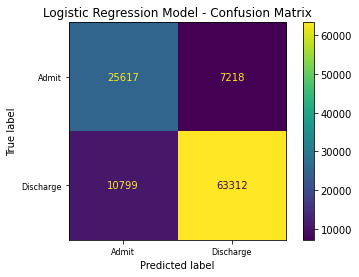

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(clf,X_test,y_test)
plt.title("Logistic Regression Model - Confusion Matrix")
plt.xticks(range(2), ["Admit", "Discharge"], fontsize=8)
plt.yticks(range(2), ["Admit", "Discharge"], fontsize=8)
plt.show()

## Precision Recall curve

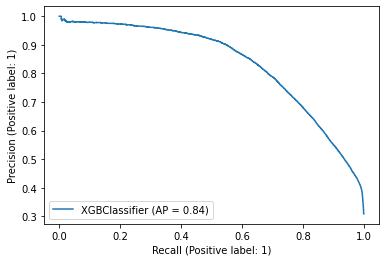

In [17]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
plot_precision_recall_curve(clf,X_test,y_test,pos_label=1)

## ROC curve

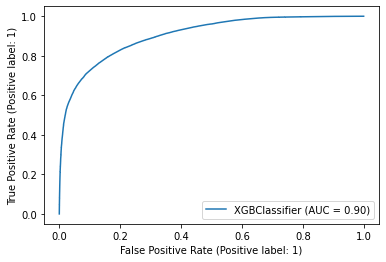

In [18]:
plot_roc_curve(clf,X_test,y_test,pos_label=1)

## Quantative matrix

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score

print(classification_report(y_test, y_pred, target_names=["Admit", "Discharge"]))
print("Balanced Accuracy:" + format(balanced_accuracy_score(y_test,y_pred),'.2f'))
print("Matthews Corr Coef:" + format(matthews_corrcoef(y_test,y_pred),'.2f'))

              precision    recall  f1-score   support

       Admit       0.70      0.78      0.74     32835
   Discharge       0.90      0.85      0.88     74111

    accuracy                           0.83    106946
   macro avg       0.80      0.82      0.81    106946
weighted avg       0.84      0.83      0.83    106946

Balanced Accuracy:0.82
Matthews Corr Coef:0.62


## Statistic measurement of the model

In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import roc_auc_score, average_precision_score
from prettytable import PrettyTable
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
MCCs = []
auROCs = []
auPRCs = []

accuracy_scores.append(accuracy_score(y_true=y_test, y_pred=y_pred))
f1_scores.append(f1_score(y_true=y_test, y_pred=y_pred))
recall_scores.append(recall_score(y_true=y_test, y_pred=y_pred))
precision_scores.append(precision_score(y_true=y_test, y_pred=y_pred))
MCCs.append(matthews_corrcoef(y_true=y_test, y_pred=y_pred))
auROCs.append(roc_auc_score(y_true=y_test, y_score=clf.predict_proba(X_test)[:, 1]))
auPRCs.append(average_precision_score(y_true=y_test,  y_score=clf.predict_proba(X_test)[:, 0]))

table = PrettyTable()
column_names = ['Accuracy', 'auROC', 'auPRC', 'recall', 'precision', 'f1', 'MCC']
table.add_column(column_names[0], np.round(accuracy_scores, 4))
table.add_column(column_names[1], np.round(auROCs, 4))
table.add_column(column_names[2], np.round(auPRCs, 4))
table.add_column(column_names[3], np.round(recall_scores, 4))
table.add_column(column_names[4], np.round(precision_scores, 4))
table.add_column(column_names[5], np.round(f1_scores, 4))
table.add_column(column_names[6], np.round(MCCs, 4))


print(table)

+----------+--------+--------+--------+-----------+--------+--------+
| Accuracy | auROC  | auPRC  | recall | precision |   f1   |  MCC   |
+----------+--------+--------+--------+-----------+--------+--------+
|  0.8315  | 0.9044 | 0.8366 | 0.7802 |   0.7035  | 0.7398 | 0.6176 |
+----------+--------+--------+--------+-----------+--------+--------+


## Visualize the feature importance function

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

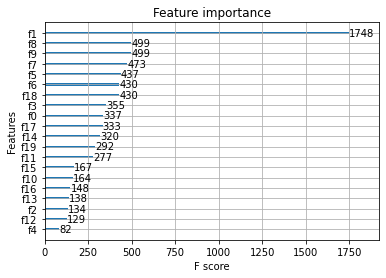

In [21]:
%matplotlib inline

xgb.plot_importance(clf)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

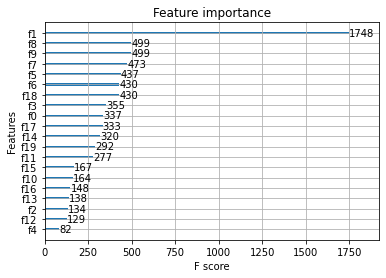

In [22]:
%matplotlib inline

xgb.plot_importance(clf)
